## Preprocessing

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib
import os
import re
from transformers import BertTokenizer

# Load and preprocess the dataset
dataset = pd.read_excel('data/data.xlsx')
dataset = dataset.dropna(subset=['feature_1'])

# This must be updated if a column is added or removed from the dataset
target_columns = [
    'target_1', 'target_2', 'target_3', 
    'target_4', 'target_5', 'target_6', 'target_7', 
    'target_8', 'target_9', 'target_10', 'target_11', 
    'target_12', 'target_13', 'target_14', 'target_15'
    ]

# Lowercase all text in the relevant columns
for column in target_columns:
    dataset[column] = dataset[column].str.lower()
    dataset[column] = dataset[column].fillna('unknown')

# Create the combined_features column
dataset['combined_features'] = dataset.apply(lambda row: ' '.join([
    row['feature_1'],
    row['feature_2'] if pd.notna(row['feature_2']) else '',
    row['feature_3'] if pd.notna(row['feature_3']) else '',
    row['feature_4'] if pd.notna(row['feature_4']) else ''
    ]), axis=1)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize combined features
dataset['tokenized'] = dataset['combined_features'].apply(lambda x: tokenizer.encode_plus(
    x, add_special_tokens=True, max_length=128, padding='max_length', truncation=True, return_tensors='pt'
))

# Convert tensors to lists for saving
dataset['tokenized'] = dataset['tokenized'].apply(lambda x: {
    'input_ids': x['input_ids'].tolist(),
    'attention_mask': x['attention_mask'].tolist()
})

# Directory to save the label encoders
label_encoder_dir = 'label_encoders'
os.makedirs(label_encoder_dir, exist_ok=True)

# Function to create a safe filename
def safe_filename(name):
    return re.sub(r'[^a-zA-Z0-9_]', '_', name)

label_encoders = {col: LabelEncoder() for col in target_columns}
for col in target_columns:
    dataset[col] = label_encoders[col].fit_transform(dataset[col])

# Save the label encoders and count unique values for each column
num_classes_list = []
for col, le in label_encoders.items():
    safe_col = safe_filename(col)
    joblib.dump(le, os.path.join(label_encoder_dir, f'label_encoder_{safe_col}.pkl'))
    num_classes_list.append(len(le.classes_))

# Print the number of unique values for each column (number of classes for each task)
for col, num_classes in zip(target_columns, num_classes_list):
    print(f"Column: {col}, Number of classes: {num_classes}")

dataset.to_csv('preprocessed_dataset.csv', index=False)

# Save the tokenized column as well in a separate file
dataset[['tokenized']].to_pickle('tokenized_dataset.pkl')

# Save num_classes_list to a file
joblib.dump(num_classes_list, 'num_classes_list.pkl')


## Model definition and hyperparameter tuning

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from transformers import BertModel, BertTokenizer
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchmetrics
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import joblib
import os

torch.set_float32_matmul_precision('high')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is set to:", device)

class SumOfAccuracies(torchmetrics.Metric):
    def __init__(self):
        super().__init__()
        self.add_state("sum_accuracies", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("n_batches", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, logits, labels):
        accuracies = []
        for logit, label in zip(logits, labels):
            preds = torch.argmax(logit, dim=1)
            accuracy = (preds == label).float().mean()
            accuracies.append(accuracy)
        self.sum_accuracies += torch.sum(torch.tensor(accuracies))
        self.n_batches += 1

    def compute(self):
        return self.sum_accuracies / self.n_batches

class MultiTaskBERT(pl.LightningModule):
    def __init__(self, num_classes_list, class_weights, dropout_rate, hidden_size):
        super(MultiTaskBERT, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_layer = nn.Linear(self.bert.config.hidden_size, hidden_size)
        self.activation = nn.ReLU()
        self.classification_heads = nn.ModuleList([nn.Linear(hidden_size, num_classes) for num_classes in num_classes_list])
        self.class_weights = class_weights
        self.train_sum_of_accuracies = SumOfAccuracies()
        self.val_sum_of_accuracies = SumOfAccuracies()
        self.training_accuracies = []
        self.validation_accuracies = []
        self.learning_rate = None
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        cls_output = self.dropout(cls_output)
        hidden_output = self.activation(self.hidden_layer(cls_output))
        logits = [head(hidden_output) for head in self.classification_heads]
        return logits
    
    def compute_loss(self, logits, labels):
        losses = []
        for i, (logit, label) in enumerate(zip(logits, labels)):
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights[i])
            losses.append(loss_fn(logit, label))
        return sum(losses)
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['targets'].T
        logits = self(input_ids, attention_mask)
        loss = self.compute_loss(logits, labels)
        self.train_sum_of_accuracies.update(logits, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def on_train_epoch_end(self):
        train_accuracy = self.train_sum_of_accuracies.compute()
        self.training_accuracies.append(train_accuracy.item())
        self.log('train_sum_of_accuracies_epoch', train_accuracy, on_epoch=True, prog_bar=True, logger=True)
        self.train_sum_of_accuracies.reset()
    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['targets'].T
        logits = self(input_ids, attention_mask)
        loss = self.compute_loss(logits, labels)
        self.val_sum_of_accuracies.update(logits, labels)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def on_validation_epoch_end(self):
        val_accuracy = self.val_sum_of_accuracies.compute()
        self.validation_accuracies.append(val_accuracy.item())
        self.log('val_sum_of_accuracies_epoch', val_accuracy, on_epoch=True, prog_bar=True, logger=True)
        self.val_sum_of_accuracies.reset()
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

class IndicatorDataset(Dataset):
    def __init__(self, dataframe, tokenizer, target_columns):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.target_columns = target_columns

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        tokenized = item['tokenized']
        input_ids = torch.tensor(tokenized['input_ids']).squeeze()
        attention_mask = torch.tensor(tokenized['attention_mask']).squeeze()
        targets = {col: item[col] for col in self.target_columns}
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'targets': torch.tensor(list(targets.values()), dtype=torch.long)
        }

# Load and preprocess the dataset
dataset = pd.read_csv('preprocessed_dataset.csv')

# Load the tokenized data
tokenized_data = pd.read_pickle('tokenized_dataset.pkl')

# Merge the tokenized column with the main dataset
dataset['tokenized'] = tokenized_data['tokenized']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

label_encoder_dir = 'label_encoders'
label_encoders = {col: joblib.load(os.path.join(label_encoder_dir, f'label_encoder_{safe_filename(col)}.pkl')) for col in target_columns}

class_weights = []
for col in target_columns:
    class_counts = np.bincount(dataset[col])
    weight = 1. / class_counts
    weight = torch.tensor(weight, dtype=torch.float).to(device)
    class_weights.append(weight)

train_df, val_df = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset = IndicatorDataset(train_df, tokenizer, target_columns)
val_dataset = IndicatorDataset(val_df, tokenizer, target_columns)

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    hidden_size = trial.suggest_categorical('hidden_size', [512, 768, 1024])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = MultiTaskBERT(num_classes_list, class_weights, dropout_rate, hidden_size)
    model.learning_rate = learning_rate

    checkpoint_callback = ModelCheckpoint(
        monitor='val_sum_of_accuracies_epoch',
        dirpath='checkpoints',
        filename='best-checkpoint',
        save_top_k=1,
        mode='max'
    )

    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, mode='min')

    trainer = pl.Trainer(
        max_epochs=10,
        devices=1 if torch.cuda.is_available() else 0,
        callbacks=[checkpoint_callback, early_stopping_callback],
        log_every_n_steps=1
    )
    trainer.fit(model, train_loader, val_loader)

    val_accuracy = trainer.callback_metrics["val_sum_of_accuracies_epoch"].item()
    return val_accuracy


# Do not run the lines below if you just need to retrain the model as the tuning can take a long time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)

best_params = study.best_params
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']
dropout_rate = best_params['dropout_rate']
hidden_size = best_params['hidden_size']

Device is set to: cuda


[I 2024-07-15 16:08:43,627] A new study created in memory with name: no-name-778bde6b-b0f2-4f3f-bd8a-6e7837ee37d3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
y:\Community Project\UC3\Model\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory Y:\Community Project\UC3\Model\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accur

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

y:\Community Project\UC3\Model\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
y:\Community Project\UC3\Model\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


y:\Community Project\UC3\Model\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 8: 100%|██████████| 53/53 [00:09<00:00,  5.32it/s, v_num=66, train_loss_step=12.30, val_loss_step=18.10, val_loss_epoch=31.60, val_sum_of_accuracies_epoch=12.00, train_loss_epoch=14.70, train_sum_of_accuracies_epoch=13.20]


[I 2024-07-15 16:10:14,180] Trial 0 finished with value: 12.014880180358887 and parameters: {'learning_rate': 3.768086130810275e-05, 'batch_size': 16, 'dropout_rate': 0.19603083357039122, 'hidden_size': 1024}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
----------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  8.84it/s, v_num=67, train_loss_step=14.90, val_loss_step=20.50, val_loss_epoch=32.10, val_sum_of_accuracies_epoch=11.70, train_loss_epoch=14.50, train_sum_of_accuracies_epoch=12.80]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:10<00:00,  5.13it/s, v_num=67, train_loss_step=14.90, val_loss_step=20.50, val_loss_epoch=32.10, val_sum_of_accuracies_epoch=11.70, train_loss_epoch=14.50, train_sum_of_accuracies_epoch=12.80]


[I 2024-07-15 16:11:48,428] Trial 1 finished with value: 11.736607551574707 and parameters: {'learning_rate': 5.545470414337198e-05, 'batch_size': 16, 'dropout_rate': 0.48907660587183965, 'hidden_size': 768}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
-----------

Epoch 9: 100%|██████████| 14/14 [00:04<00:00,  3.20it/s, v_num=68, train_loss_step=26.90, val_loss_step=33.50, val_loss_epoch=34.10, val_sum_of_accuracies_epoch=9.830, train_loss_epoch=25.80, train_sum_of_accuracies_epoch=10.10]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, v_num=68, train_loss_step=26.90, val_loss_step=33.50, val_loss_epoch=34.10, val_sum_of_accuracies_epoch=9.830, train_loss_epoch=25.80, train_sum_of_accuracies_epoch=10.10]


[I 2024-07-15 16:13:12,767] Trial 2 finished with value: 9.830592155456543 and parameters: {'learning_rate': 2.8024133996961155e-05, 'batch_size': 64, 'dropout_rate': 0.3269115331958983, 'hidden_size': 1024}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
-----------

Epoch 3: 100%|██████████| 27/27 [00:04<00:00,  5.46it/s, v_num=69, train_loss_step=34.90, val_loss_step=38.30, val_loss_epoch=39.20, val_sum_of_accuracies_epoch=5.970, train_loss_epoch=36.10, train_sum_of_accuracies_epoch=6.280]


[I 2024-07-15 16:13:46,401] Trial 3 finished with value: 5.974624156951904 and parameters: {'learning_rate': 0.0007000838401157563, 'batch_size': 32, 'dropout_rate': 0.11678576404986729, 'hidden_size': 512}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
------------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.62it/s, v_num=70, train_loss_step=24.00, val_loss_step=26.60, val_loss_epoch=32.30, val_sum_of_accuracies_epoch=11.40, train_loss_epoch=24.60, train_sum_of_accuracies_epoch=12.20]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.46it/s, v_num=70, train_loss_step=24.00, val_loss_step=26.60, val_loss_epoch=32.30, val_sum_of_accuracies_epoch=11.40, train_loss_epoch=24.60, train_sum_of_accuracies_epoch=12.20]


[I 2024-07-15 16:15:28,351] Trial 4 finished with value: 11.391369819641113 and parameters: {'learning_rate': 1.1416477313495242e-05, 'batch_size': 16, 'dropout_rate': 0.20564507059062265, 'hidden_size': 1024}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 27/27 [00:04<00:00,  5.90it/s, v_num=71, train_loss_step=28.70, val_loss_step=33.30, val_loss_epoch=34.10, val_sum_of_accuracies_epoch=8.810, train_loss_epoch=27.50, train_sum_of_accuracies_epoch=9.280]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:08<00:00,  3.12it/s, v_num=71, train_loss_step=28.70, val_loss_step=33.30, val_loss_epoch=34.10, val_sum_of_accuracies_epoch=8.810, train_loss_epoch=27.50, train_sum_of_accuracies_epoch=9.280]


[I 2024-07-15 16:16:57,150] Trial 5 finished with value: 8.808035850524902 and parameters: {'learning_rate': 1.3988255289951799e-05, 'batch_size': 32, 'dropout_rate': 0.31026022099907724, 'hidden_size': 1024}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
----------

Epoch 3: 100%|██████████| 27/27 [00:04<00:00,  5.69it/s, v_num=72, train_loss_step=34.20, val_loss_step=38.70, val_loss_epoch=39.30, val_sum_of_accuracies_epoch=5.590, train_loss_epoch=36.40, train_sum_of_accuracies_epoch=5.350]


[I 2024-07-15 16:17:30,239] Trial 6 finished with value: 5.59328031539917 and parameters: {'learning_rate': 0.0005586319514434691, 'batch_size': 32, 'dropout_rate': 0.43386576488356143, 'hidden_size': 768}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
-------------

Epoch 3: 100%|██████████| 53/53 [00:09<00:00,  5.33it/s, v_num=73, train_loss_step=35.40, val_loss_step=33.40, val_loss_epoch=38.50, val_sum_of_accuracies_epoch=8.270, train_loss_epoch=35.50, train_sum_of_accuracies_epoch=7.190]


[I 2024-07-15 16:18:06,631] Trial 7 finished with value: 8.2693452835083 and parameters: {'learning_rate': 0.00032319619881657436, 'batch_size': 16, 'dropout_rate': 0.29871157488084876, 'hidden_size': 1024}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
------------

Epoch 3: 100%|██████████| 14/14 [00:04<00:00,  3.33it/s, v_num=74, train_loss_step=35.20, val_loss_step=38.60, val_loss_epoch=39.80, val_sum_of_accuracies_epoch=6.080, train_loss_epoch=36.70, train_sum_of_accuracies_epoch=4.810]


[I 2024-07-15 16:18:37,582] Trial 8 finished with value: 6.076068878173828 and parameters: {'learning_rate': 0.0007223233196036039, 'batch_size': 64, 'dropout_rate': 0.4471572297679909, 'hidden_size': 512}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
-------------

Epoch 8: 100%|██████████| 14/14 [00:04<00:00,  3.15it/s, v_num=75, train_loss_step=16.70, val_loss_step=30.00, val_loss_epoch=34.30, val_sum_of_accuracies_epoch=10.90, train_loss_epoch=17.10, train_sum_of_accuracies_epoch=12.10]


[I 2024-07-15 16:19:50,260] Trial 9 finished with value: 10.933182716369629 and parameters: {'learning_rate': 9.739856933675041e-05, 'batch_size': 64, 'dropout_rate': 0.19691744749608942, 'hidden_size': 512}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
-----------

Epoch 3: 100%|██████████| 53/53 [00:06<00:00,  8.31it/s, v_num=76, train_loss_step=34.00, val_loss_step=33.40, val_loss_epoch=38.50, val_sum_of_accuracies_epoch=6.660, train_loss_epoch=35.40, train_sum_of_accuracies_epoch=7.710]


[I 2024-07-15 16:20:28,352] Trial 10 finished with value: 6.663690090179443 and parameters: {'learning_rate': 0.00018998019567324968, 'batch_size': 16, 'dropout_rate': 0.10590043803430588, 'hidden_size': 1024}. Best is trial 0 with value: 12.014880180358887.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.22it/s, v_num=77, train_loss_step=14.60, val_loss_step=18.90, val_loss_epoch=32.20, val_sum_of_accuracies_epoch=12.00, train_loss_epoch=15.10, train_sum_of_accuracies_epoch=12.70]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.37it/s, v_num=77, train_loss_step=14.60, val_loss_step=18.90, val_loss_epoch=32.20, val_sum_of_accuracies_epoch=12.00, train_loss_epoch=15.10, train_sum_of_accuracies_epoch=12.70]


[I 2024-07-15 16:22:07,476] Trial 11 finished with value: 12.049107551574707 and parameters: {'learning_rate': 5.631422171980421e-05, 'batch_size': 16, 'dropout_rate': 0.49826899269331254, 'hidden_size': 768}. Best is trial 11 with value: 12.049107551574707.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.48it/s, v_num=78, train_loss_step=12.70, val_loss_step=18.50, val_loss_epoch=32.10, val_sum_of_accuracies_epoch=12.30, train_loss_epoch=13.40, train_sum_of_accuracies_epoch=13.30]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.45it/s, v_num=78, train_loss_step=12.70, val_loss_step=18.50, val_loss_epoch=32.10, val_sum_of_accuracies_epoch=12.30, train_loss_epoch=13.40, train_sum_of_accuracies_epoch=13.30]


[I 2024-07-15 16:23:43,473] Trial 12 finished with value: 12.325892448425293 and parameters: {'learning_rate': 4.332851588255876e-05, 'batch_size': 16, 'dropout_rate': 0.22652594447934843, 'hidden_size': 768}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 8: 100%|██████████| 53/53 [00:06<00:00,  8.83it/s, v_num=79, train_loss_step=16.10, val_loss_step=15.60, val_loss_epoch=32.30, val_sum_of_accuracies_epoch=10.90, train_loss_epoch=13.20, train_sum_of_accuracies_epoch=11.80]


[I 2024-07-15 16:25:03,075] Trial 13 finished with value: 10.892857551574707 and parameters: {'learning_rate': 0.00012124130813676354, 'batch_size': 16, 'dropout_rate': 0.35934667574069346, 'hidden_size': 768}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 8: 100%|██████████| 53/53 [00:06<00:00,  8.56it/s, v_num=80, train_loss_step=12.40, val_loss_step=17.10, val_loss_epoch=31.50, val_sum_of_accuracies_epoch=11.70, train_loss_epoch=12.00, train_sum_of_accuracies_epoch=13.10]


[I 2024-07-15 16:26:27,346] Trial 14 finished with value: 11.720237731933594 and parameters: {'learning_rate': 5.917739072364451e-05, 'batch_size': 16, 'dropout_rate': 0.2583094704289978, 'hidden_size': 768}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
----------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.35it/s, v_num=81, train_loss_step=21.80, val_loss_step=22.30, val_loss_epoch=32.00, val_sum_of_accuracies_epoch=11.80, train_loss_epoch=20.80, train_sum_of_accuracies_epoch=12.40]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:10<00:00,  5.28it/s, v_num=81, train_loss_step=21.80, val_loss_step=22.30, val_loss_epoch=32.00, val_sum_of_accuracies_epoch=11.80, train_loss_epoch=20.80, train_sum_of_accuracies_epoch=12.40]


[I 2024-07-15 16:28:09,033] Trial 15 finished with value: 11.785714149475098 and parameters: {'learning_rate': 2.3147184778850627e-05, 'batch_size': 16, 'dropout_rate': 0.383597881072141, 'hidden_size': 768}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
----------

Epoch 7: 100%|██████████| 53/53 [00:05<00:00,  9.55it/s, v_num=82, train_loss_step=13.50, val_loss_step=15.90, val_loss_epoch=31.00, val_sum_of_accuracies_epoch=11.50, train_loss_epoch=11.90, train_sum_of_accuracies_epoch=12.50]


[I 2024-07-15 16:29:18,976] Trial 16 finished with value: 11.5 and parameters: {'learning_rate': 8.869964580265404e-05, 'batch_size': 16, 'dropout_rate': 0.2491317748919476, 'hidden_size': 768}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
------------------------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.58it/s, v_num=83, train_loss_step=19.20, val_loss_step=25.50, val_loss_epoch=32.50, val_sum_of_accuracies_epoch=11.60, train_loss_epoch=22.30, train_sum_of_accuracies_epoch=12.10]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.54it/s, v_num=83, train_loss_step=19.20, val_loss_step=25.50, val_loss_epoch=32.50, val_sum_of_accuracies_epoch=11.60, train_loss_epoch=22.30, train_sum_of_accuracies_epoch=12.10]


[I 2024-07-15 16:30:56,286] Trial 17 finished with value: 11.633928298950195 and parameters: {'learning_rate': 1.939438094575492e-05, 'batch_size': 16, 'dropout_rate': 0.39359094376818526, 'hidden_size': 768}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 14/14 [00:04<00:00,  3.40it/s, v_num=84, train_loss_step=19.90, val_loss_step=32.20, val_loss_epoch=34.50, val_sum_of_accuracies_epoch=10.80, train_loss_epoch=21.50, train_sum_of_accuracies_epoch=11.20]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, v_num=84, train_loss_step=19.90, val_loss_step=32.20, val_loss_epoch=34.50, val_sum_of_accuracies_epoch=10.80, train_loss_epoch=21.50, train_sum_of_accuracies_epoch=11.20]


[I 2024-07-15 16:32:19,897] Trial 18 finished with value: 10.7600736618042 and parameters: {'learning_rate': 4.359047713311948e-05, 'batch_size': 64, 'dropout_rate': 0.1579784451431162, 'hidden_size': 768}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
------------

Epoch 3: 100%|██████████| 27/27 [00:04<00:00,  6.03it/s, v_num=85, train_loss_step=34.00, val_loss_step=38.60, val_loss_epoch=39.70, val_sum_of_accuracies_epoch=4.820, train_loss_epoch=34.00, train_sum_of_accuracies_epoch=5.710]


[I 2024-07-15 16:32:47,283] Trial 19 finished with value: 4.816729545593262 and parameters: {'learning_rate': 0.00020179453978490816, 'batch_size': 32, 'dropout_rate': 0.2604188871223648, 'hidden_size': 768}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
----------

Epoch 3: 100%|██████████| 53/53 [00:05<00:00,  9.76it/s, v_num=86, train_loss_step=36.70, val_loss_step=33.10, val_loss_epoch=38.20, val_sum_of_accuracies_epoch=6.920, train_loss_epoch=35.50, train_sum_of_accuracies_epoch=7.370]


[I 2024-07-15 16:33:18,442] Trial 20 finished with value: 6.922618865966797 and parameters: {'learning_rate': 0.00015630944855040012, 'batch_size': 16, 'dropout_rate': 0.47464716781522803, 'hidden_size': 768}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 7: 100%|██████████| 53/53 [00:09<00:00,  5.42it/s, v_num=87, train_loss_step=13.70, val_loss_step=17.80, val_loss_epoch=32.00, val_sum_of_accuracies_epoch=12.30, train_loss_epoch=15.20, train_sum_of_accuracies_epoch=13.10]


[I 2024-07-15 16:34:37,003] Trial 21 finished with value: 12.296130180358887 and parameters: {'learning_rate': 4.147309249563208e-05, 'batch_size': 16, 'dropout_rate': 0.1928047127947602, 'hidden_size': 1024}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 7: 100%|██████████| 53/53 [00:09<00:00,  5.38it/s, v_num=88, train_loss_step=12.10, val_loss_step=17.80, val_loss_epoch=31.60, val_sum_of_accuracies_epoch=12.00, train_loss_epoch=11.40, train_sum_of_accuracies_epoch=13.00]


[I 2024-07-15 16:35:56,934] Trial 22 finished with value: 12.037201881408691 and parameters: {'learning_rate': 6.554613902166981e-05, 'batch_size': 16, 'dropout_rate': 0.16807063189773752, 'hidden_size': 1024}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.57it/s, v_num=89, train_loss_step=15.20, val_loss_step=21.50, val_loss_epoch=32.70, val_sum_of_accuracies_epoch=12.20, train_loss_epoch=16.60, train_sum_of_accuracies_epoch=13.40]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.41it/s, v_num=89, train_loss_step=15.20, val_loss_step=21.50, val_loss_epoch=32.70, val_sum_of_accuracies_epoch=12.20, train_loss_epoch=16.60, train_sum_of_accuracies_epoch=13.40]


[I 2024-07-15 16:37:35,982] Trial 23 finished with value: 12.208333969116211 and parameters: {'learning_rate': 3.2615989766318565e-05, 'batch_size': 16, 'dropout_rate': 0.22762563340004888, 'hidden_size': 512}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 8: 100%|██████████| 53/53 [00:09<00:00,  5.49it/s, v_num=90, train_loss_step=17.20, val_loss_step=20.20, val_loss_epoch=31.10, val_sum_of_accuracies_epoch=12.00, train_loss_epoch=17.40, train_sum_of_accuracies_epoch=12.90]


[I 2024-07-15 16:39:05,385] Trial 24 finished with value: 12.026785850524902 and parameters: {'learning_rate': 3.556099031402705e-05, 'batch_size': 16, 'dropout_rate': 0.23246450883363703, 'hidden_size': 512}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.58it/s, v_num=91, train_loss_step=21.20, val_loss_step=25.30, val_loss_epoch=31.80, val_sum_of_accuracies_epoch=11.90, train_loss_epoch=21.60, train_sum_of_accuracies_epoch=12.80]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.51it/s, v_num=91, train_loss_step=21.20, val_loss_step=25.30, val_loss_epoch=31.80, val_sum_of_accuracies_epoch=11.90, train_loss_epoch=21.60, train_sum_of_accuracies_epoch=12.80]


[I 2024-07-15 16:40:42,407] Trial 25 finished with value: 11.919642448425293 and parameters: {'learning_rate': 1.6935009766574014e-05, 'batch_size': 16, 'dropout_rate': 0.1570923999637709, 'hidden_size': 512}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.61it/s, v_num=92, train_loss_step=19.40, val_loss_step=21.70, val_loss_epoch=31.40, val_sum_of_accuracies_epoch=12.00, train_loss_epoch=18.50, train_sum_of_accuracies_epoch=13.10]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.53it/s, v_num=92, train_loss_step=19.40, val_loss_step=21.70, val_loss_epoch=31.40, val_sum_of_accuracies_epoch=12.00, train_loss_epoch=18.50, train_sum_of_accuracies_epoch=13.10]


[I 2024-07-15 16:42:19,374] Trial 26 finished with value: 12.010416030883789 and parameters: {'learning_rate': 2.8407887130287464e-05, 'batch_size': 16, 'dropout_rate': 0.27768120648969435, 'hidden_size': 512}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 8: 100%|██████████| 53/53 [00:09<00:00,  5.59it/s, v_num=93, train_loss_step=9.360, val_loss_step=16.30, val_loss_epoch=33.00, val_sum_of_accuracies_epoch=12.10, train_loss_epoch=12.60, train_sum_of_accuracies_epoch=12.80]


[I 2024-07-15 16:43:42,713] Trial 27 finished with value: 12.09375 and parameters: {'learning_rate': 8.25102323869135e-05, 'batch_size': 16, 'dropout_rate': 0.2251591267397518, 'hidden_size': 512}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------------------

Epoch 9: 100%|██████████| 27/27 [00:04<00:00,  5.96it/s, v_num=94, train_loss_step=19.30, val_loss_step=28.70, val_loss_epoch=32.50, val_sum_of_accuracies_epoch=10.60, train_loss_epoch=18.30, train_sum_of_accuracies_epoch=12.00]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:04<00:00,  5.96it/s, v_num=94, train_loss_step=19.30, val_loss_step=28.70, val_loss_epoch=32.50, val_sum_of_accuracies_epoch=10.60, train_loss_epoch=18.30, train_sum_of_accuracies_epoch=12.00]


[I 2024-07-15 16:45:06,024] Trial 28 finished with value: 10.63933277130127 and parameters: {'learning_rate': 4.2102756787919215e-05, 'batch_size': 32, 'dropout_rate': 0.18149948858212586, 'hidden_size': 512}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 14/14 [00:04<00:00,  3.39it/s, v_num=95, train_loss_step=31.70, val_loss_step=34.60, val_loss_epoch=35.30, val_sum_of_accuracies_epoch=7.380, train_loss_epoch=30.70, train_sum_of_accuracies_epoch=7.650]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, v_num=95, train_loss_step=31.70, val_loss_step=34.60, val_loss_epoch=35.30, val_sum_of_accuracies_epoch=7.380, train_loss_epoch=30.70, train_sum_of_accuracies_epoch=7.650]


[I 2024-07-15 16:46:28,661] Trial 29 finished with value: 7.3787007331848145 and parameters: {'learning_rate': 1.0122865501730913e-05, 'batch_size': 64, 'dropout_rate': 0.14468465999219587, 'hidden_size': 1024}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
-------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.99it/s, v_num=96, train_loss_step=17.70, val_loss_step=18.10, val_loss_epoch=31.20, val_sum_of_accuracies_epoch=12.00, train_loss_epoch=13.50, train_sum_of_accuracies_epoch=13.60]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.98it/s, v_num=96, train_loss_step=17.70, val_loss_step=18.10, val_loss_epoch=31.20, val_sum_of_accuracies_epoch=12.00, train_loss_epoch=13.50, train_sum_of_accuracies_epoch=13.60]


[I 2024-07-15 16:47:57,002] Trial 30 finished with value: 11.998512268066406 and parameters: {'learning_rate': 3.523987619721355e-05, 'batch_size': 16, 'dropout_rate': 0.2222341397240088, 'hidden_size': 1024}. Best is trial 12 with value: 12.325892448425293.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.61it/s, v_num=97, train_loss_step=7.860, val_loss_step=15.30, val_loss_epoch=33.90, val_sum_of_accuracies_epoch=12.40, train_loss_epoch=9.880, train_sum_of_accuracies_epoch=13.60]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.50it/s, v_num=97, train_loss_step=7.860, val_loss_step=15.30, val_loss_epoch=33.90, val_sum_of_accuracies_epoch=12.40, train_loss_epoch=9.880, train_sum_of_accuracies_epoch=13.60]


[I 2024-07-15 16:49:30,743] Trial 31 finished with value: 12.430059432983398 and parameters: {'learning_rate': 7.733232578174702e-05, 'batch_size': 16, 'dropout_rate': 0.20615965554535598, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 7: 100%|██████████| 53/53 [00:09<00:00,  5.54it/s, v_num=98, train_loss_step=17.50, val_loss_step=19.40, val_loss_epoch=31.90, val_sum_of_accuracies_epoch=12.10, train_loss_epoch=16.10, train_sum_of_accuracies_epoch=13.00]


[I 2024-07-15 16:50:49,000] Trial 32 finished with value: 12.141369819641113 and parameters: {'learning_rate': 4.5983779410277844e-05, 'batch_size': 16, 'dropout_rate': 0.13561820627352303, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.56it/s, v_num=99, train_loss_step=17.00, val_loss_step=21.20, val_loss_epoch=32.20, val_sum_of_accuracies_epoch=12.30, train_loss_epoch=18.10, train_sum_of_accuracies_epoch=13.30]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.50it/s, v_num=99, train_loss_step=17.00, val_loss_step=21.20, val_loss_epoch=32.20, val_sum_of_accuracies_epoch=12.30, train_loss_epoch=18.10, train_sum_of_accuracies_epoch=13.30]


[I 2024-07-15 16:52:26,662] Trial 33 finished with value: 12.3244047164917 and parameters: {'learning_rate': 2.7383821742211344e-05, 'batch_size': 16, 'dropout_rate': 0.1921173670423511, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
-----------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.55it/s, v_num=100, train_loss_step=20.50, val_loss_step=24.80, val_loss_epoch=31.50, val_sum_of_accuracies_epoch=11.90, train_loss_epoch=19.80, train_sum_of_accuracies_epoch=13.00]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.45it/s, v_num=100, train_loss_step=20.50, val_loss_step=24.80, val_loss_epoch=31.50, val_sum_of_accuracies_epoch=11.90, train_loss_epoch=19.80, train_sum_of_accuracies_epoch=13.00]


[I 2024-07-15 16:54:04,716] Trial 34 finished with value: 11.880951881408691 and parameters: {'learning_rate': 2.2762560282142008e-05, 'batch_size': 16, 'dropout_rate': 0.18395279227525357, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.87it/s, v_num=101, train_loss_step=8.120, val_loss_step=15.00, val_loss_epoch=35.50, val_sum_of_accuracies_epoch=11.90, train_loss_epoch=9.210, train_sum_of_accuracies_epoch=12.70]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.57it/s, v_num=101, train_loss_step=8.120, val_loss_step=15.00, val_loss_epoch=35.50, val_sum_of_accuracies_epoch=11.90, train_loss_epoch=9.210, train_sum_of_accuracies_epoch=12.70]


[I 2024-07-15 16:55:34,496] Trial 35 finished with value: 11.933035850524902 and parameters: {'learning_rate': 0.00013495503878139576, 'batch_size': 16, 'dropout_rate': 0.19482187173856483, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 7: 100%|██████████| 53/53 [00:09<00:00,  5.48it/s, v_num=102, train_loss_step=10.00, val_loss_step=14.80, val_loss_epoch=32.20, val_sum_of_accuracies_epoch=12.20, train_loss_epoch=10.10, train_sum_of_accuracies_epoch=13.30]


[I 2024-07-15 16:56:54,085] Trial 36 finished with value: 12.2068452835083 and parameters: {'learning_rate': 6.939722973852565e-05, 'batch_size': 16, 'dropout_rate': 0.13427145334478358, 'hidden_size': 1024}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
----------

Epoch 9: 100%|██████████| 27/27 [00:04<00:00,  5.92it/s, v_num=103, train_loss_step=15.70, val_loss_step=29.80, val_loss_epoch=33.20, val_sum_of_accuracies_epoch=11.60, train_loss_epoch=14.90, train_sum_of_accuracies_epoch=12.40]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:08<00:00,  3.09it/s, v_num=103, train_loss_step=15.70, val_loss_step=29.80, val_loss_epoch=33.20, val_sum_of_accuracies_epoch=11.60, train_loss_epoch=14.90, train_sum_of_accuracies_epoch=12.40]


[I 2024-07-15 16:58:18,586] Trial 37 finished with value: 11.622885704040527 and parameters: {'learning_rate': 4.79672435903376e-05, 'batch_size': 32, 'dropout_rate': 0.20676065663981905, 'hidden_size': 1024}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.55it/s, v_num=104, train_loss_step=23.30, val_loss_step=28.10, val_loss_epoch=32.90, val_sum_of_accuracies_epoch=11.10, train_loss_epoch=24.90, train_sum_of_accuracies_epoch=11.60]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.50it/s, v_num=104, train_loss_step=23.30, val_loss_step=28.10, val_loss_epoch=32.90, val_sum_of_accuracies_epoch=11.10, train_loss_epoch=24.90, train_sum_of_accuracies_epoch=11.60]


[I 2024-07-15 16:59:56,585] Trial 38 finished with value: 11.129464149475098 and parameters: {'learning_rate': 1.3946108335242048e-05, 'batch_size': 16, 'dropout_rate': 0.29258489312460617, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.40it/s, v_num=105, train_loss_step=20.40, val_loss_step=22.80, val_loss_epoch=32.00, val_sum_of_accuracies_epoch=11.80, train_loss_epoch=18.80, train_sum_of_accuracies_epoch=13.00]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.39it/s, v_num=105, train_loss_step=20.40, val_loss_step=22.80, val_loss_epoch=32.00, val_sum_of_accuracies_epoch=11.80, train_loss_epoch=18.80, train_sum_of_accuracies_epoch=13.00]


[I 2024-07-15 17:01:26,639] Trial 39 finished with value: 11.848214149475098 and parameters: {'learning_rate': 2.3267101462606284e-05, 'batch_size': 16, 'dropout_rate': 0.27688250755041793, 'hidden_size': 1024}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
-------

Epoch 3: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s, v_num=106, train_loss_step=35.60, val_loss_step=38.80, val_loss_epoch=40.40, val_sum_of_accuracies_epoch=6.540, train_loss_epoch=36.30, train_sum_of_accuracies_epoch=4.640]


[I 2024-07-15 17:01:52,280] Trial 40 finished with value: 6.541118621826172 and parameters: {'learning_rate': 0.0009835684745969028, 'batch_size': 64, 'dropout_rate': 0.12210828671680943, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
----------

Epoch 8: 100%|██████████| 53/53 [00:09<00:00,  5.49it/s, v_num=107, train_loss_step=18.50, val_loss_step=19.90, val_loss_epoch=32.40, val_sum_of_accuracies_epoch=12.10, train_loss_epoch=18.40, train_sum_of_accuracies_epoch=12.90]


[I 2024-07-15 17:03:20,130] Trial 41 finished with value: 12.099701881408691 and parameters: {'learning_rate': 3.519387242174263e-05, 'batch_size': 16, 'dropout_rate': 0.23932082185718268, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.43it/s, v_num=108, train_loss_step=19.20, val_loss_step=24.20, val_loss_epoch=31.60, val_sum_of_accuracies_epoch=11.70, train_loss_epoch=18.90, train_sum_of_accuracies_epoch=12.60]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.42it/s, v_num=108, train_loss_step=19.20, val_loss_step=24.20, val_loss_epoch=31.60, val_sum_of_accuracies_epoch=11.70, train_loss_epoch=18.90, train_sum_of_accuracies_epoch=12.60]


[I 2024-07-15 17:04:59,653] Trial 42 finished with value: 11.690476417541504 and parameters: {'learning_rate': 2.9278523691352334e-05, 'batch_size': 16, 'dropout_rate': 0.32413110696830355, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 8: 100%|██████████| 53/53 [00:09<00:00,  5.40it/s, v_num=109, train_loss_step=12.70, val_loss_step=16.40, val_loss_epoch=31.80, val_sum_of_accuracies_epoch=11.80, train_loss_epoch=12.40, train_sum_of_accuracies_epoch=13.00]


[I 2024-07-15 17:06:29,151] Trial 43 finished with value: 11.808035850524902 and parameters: {'learning_rate': 7.535582167054855e-05, 'batch_size': 16, 'dropout_rate': 0.2158494081487355, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
----------

Epoch 8: 100%|██████████| 53/53 [00:05<00:00,  9.49it/s, v_num=110, train_loss_step=14.20, val_loss_step=16.80, val_loss_epoch=32.00, val_sum_of_accuracies_epoch=12.20, train_loss_epoch=13.00, train_sum_of_accuracies_epoch=13.40]


[I 2024-07-15 17:07:54,540] Trial 44 finished with value: 12.21875 and parameters: {'learning_rate': 5.4343034314366464e-05, 'batch_size': 16, 'dropout_rate': 0.18235827943902194, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
------------------

Epoch 9: 100%|██████████| 27/27 [00:04<00:00,  5.86it/s, v_num=111, train_loss_step=8.820, val_loss_step=28.00, val_loss_epoch=34.60, val_sum_of_accuracies_epoch=11.30, train_loss_epoch=9.510, train_sum_of_accuracies_epoch=12.60]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 27/27 [00:08<00:00,  3.08it/s, v_num=111, train_loss_step=8.820, val_loss_step=28.00, val_loss_epoch=34.60, val_sum_of_accuracies_epoch=11.30, train_loss_epoch=9.510, train_sum_of_accuracies_epoch=12.60]


[I 2024-07-15 17:09:24,345] Trial 45 finished with value: 11.315085411071777 and parameters: {'learning_rate': 0.00010676064910079692, 'batch_size': 32, 'dropout_rate': 0.17616193840481462, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 7: 100%|██████████| 53/53 [00:09<00:00,  5.53it/s, v_num=112, train_loss_step=13.90, val_loss_step=16.90, val_loss_epoch=31.90, val_sum_of_accuracies_epoch=12.10, train_loss_epoch=13.50, train_sum_of_accuracies_epoch=13.30]


[I 2024-07-15 17:10:39,573] Trial 46 finished with value: 12.108630180358887 and parameters: {'learning_rate': 5.0186611676830596e-05, 'batch_size': 16, 'dropout_rate': 0.19934674860319462, 'hidden_size': 1024}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
-------

Epoch 9: 100%|██████████| 14/14 [00:04<00:00,  3.37it/s, v_num=113, train_loss_step=20.00, val_loss_step=29.90, val_loss_epoch=33.80, val_sum_of_accuracies_epoch=9.830, train_loss_epoch=19.20, train_sum_of_accuracies_epoch=11.00]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s, v_num=113, train_loss_step=20.00, val_loss_step=29.90, val_loss_epoch=33.80, val_sum_of_accuracies_epoch=9.830, train_loss_epoch=19.20, train_sum_of_accuracies_epoch=11.00]


[I 2024-07-15 17:12:05,391] Trial 47 finished with value: 9.828742027282715 and parameters: {'learning_rate': 5.8170811755061756e-05, 'batch_size': 64, 'dropout_rate': 0.15232797340538504, 'hidden_size': 512}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 590 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 341 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
---------

Epoch 9: 100%|██████████| 53/53 [00:05<00:00,  9.51it/s, v_num=114, train_loss_step=22.40, val_loss_step=24.10, val_loss_epoch=32.10, val_sum_of_accuracies_epoch=11.80, train_loss_epoch=21.50, train_sum_of_accuracies_epoch=12.70]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 53/53 [00:09<00:00,  5.42it/s, v_num=114, train_loss_step=22.40, val_loss_step=24.10, val_loss_epoch=32.10, val_sum_of_accuracies_epoch=11.80, train_loss_epoch=21.50, train_sum_of_accuracies_epoch=12.70]


[I 2024-07-15 17:13:44,500] Trial 48 finished with value: 11.828869819641113 and parameters: {'learning_rate': 1.7320267692146983e-05, 'batch_size': 16, 'dropout_rate': 0.18913941601515227, 'hidden_size': 768}. Best is trial 31 with value: 12.430059432983398.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 787 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 455 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------

Epoch 6: 100%|██████████| 53/53 [00:09<00:00,  5.46it/s, v_num=115, train_loss_step=12.70, val_loss_step=16.70, val_loss_epoch=32.10, val_sum_of_accuracies_epoch=11.40, train_loss_epoch=11.40, train_sum_of_accuracies_epoch=12.00]


[I 2024-07-15 17:14:50,746] Trial 49 finished with value: 11.400298118591309 and parameters: {'learning_rate': 9.868802128388015e-05, 'batch_size': 16, 'dropout_rate': 0.10878868205535006, 'hidden_size': 1024}. Best is trial 31 with value: 12.430059432983398.


Best hyperparameters:  {'learning_rate': 7.733232578174702e-05, 'batch_size': 16, 'dropout_rate': 0.20615965554535598, 'hidden_size': 512}


## Simple model training (here using the best hyperparameters)

In [3]:
# Prepare final dataloaders with best hyperparameters
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

checkpoint_callback = ModelCheckpoint(
    monitor='val_sum_of_accuracies_epoch',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='max'
)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, mode='min')

# Initialize the model with the best hyperparameters
model = MultiTaskBERT(num_classes_list, class_weights, dropout_rate, hidden_size)
model.learning_rate = learning_rate

# Train the model using PyTorch Lightning
trainer = pl.Trainer(max_epochs=500, devices=1 if torch.cuda.is_available() else 0, callbacks=[checkpoint_callback, early_stopping_callback], log_every_n_steps=1)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type            | Params | Mode 
--------------------------------------------------------------------
0 | bert                    | BertModel       | 109 M  | eval 
1 | dropout                 | Dropout         | 0      | train
2 | hidden_layer            | Linear          | 393 K  | train
3 | activation              | ReLU            | 0      | train
4 | classification_heads    | ModuleList      | 227 K  | train
5 | train_sum_of_accuracies | SumOfAccuracies | 0      | train
6 | val_sum_of_accuracies   | SumOfAccuracies | 0      | train
--------------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
440.415   Total estimated model params size (MB)


Epoch 55: 100%|██████████| 53/53 [00:05<00:00,  9.50it/s, v_num=116, train_loss_step=0.125, val_loss_step=10.50, val_loss_epoch=51.30, val_sum_of_accuracies_epoch=13.20, train_loss_epoch=0.499, train_sum_of_accuracies_epoch=15.80] 


## Run this to simply re-train the model

In [ ]:
# Using default hyperparameters for the model: Best hyperparameters:  {'learning_rate': 7.733232578174702e-05, 'batch_size': 16, 'dropout_rate': 0.20615965554535598, 'hidden_size': 512}
learning_rate = 7.733232578174702e-05
batch_size = 16
dropout_rate = 0.20615965554535598
hidden_size = 512


# Prepare final dataloaders with best hyperparameters
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

checkpoint_callback = ModelCheckpoint(
    monitor='val_sum_of_accuracies_epoch',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='max'
)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, mode='min')

# Initialize the model with the best hyperparameters
model = MultiTaskBERT(num_classes_list, class_weights, dropout_rate, hidden_size)
model.learning_rate = learning_rate

# Train the model using PyTorch Lightning
trainer = pl.Trainer(max_epochs=500, devices=1 if torch.cuda.is_available() else 0, callbacks=[checkpoint_callback, early_stopping_callback], log_every_n_steps=1)
trainer.fit(model, train_loader, val_loader)

## Evaluation

In [4]:
# Load the best model checkpoint
best_model_path = checkpoint_callback.best_model_path
best_model = MultiTaskBERT.load_from_checkpoint(best_model_path, num_classes_list=num_classes_list, class_weights=class_weights, dropout_rate=dropout_rate, hidden_size=hidden_size)

# Define a method to evaluate and print accuracies
def evaluate_and_print_accuracies(model, dataloader):
    model.eval()
    model.to(device)
    accuracies = torch.zeros(len(num_classes_list))
    counts = torch.zeros(len(num_classes_list))

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].T.to(device)

            logits = model(input_ids, attention_mask)

            for i, (logit, label) in enumerate(zip(logits, labels)):
                preds = torch.argmax(logit, dim=1)
                accuracies[i] += (preds == label).sum().item()
                counts[i] += label.size(0)

    accuracies = accuracies / counts
    for i, acc in enumerate(accuracies):
        print(f"Accuracy for task {i+1}: {acc.item():.4f}")

# Evaluate and print accuracies for the validation set
evaluate_and_print_accuracies(best_model, val_loader)

Accuracy for task 1: 0.9763
Accuracy for task 2: 0.9716
Accuracy for task 3: 0.9005
Accuracy for task 4: 0.7773
Accuracy for task 5: 0.5972
Accuracy for task 6: 0.6967
Accuracy for task 7: 0.5924
Accuracy for task 8: 0.8673
Accuracy for task 9: 0.7062
Accuracy for task 10: 0.7156
Accuracy for task 11: 0.7725
Accuracy for task 12: 0.8957
Accuracy for task 13: 0.9336
Accuracy for task 14: 0.9668
Accuracy for task 15: 0.9716
Accuracy for task 16: 0.9905


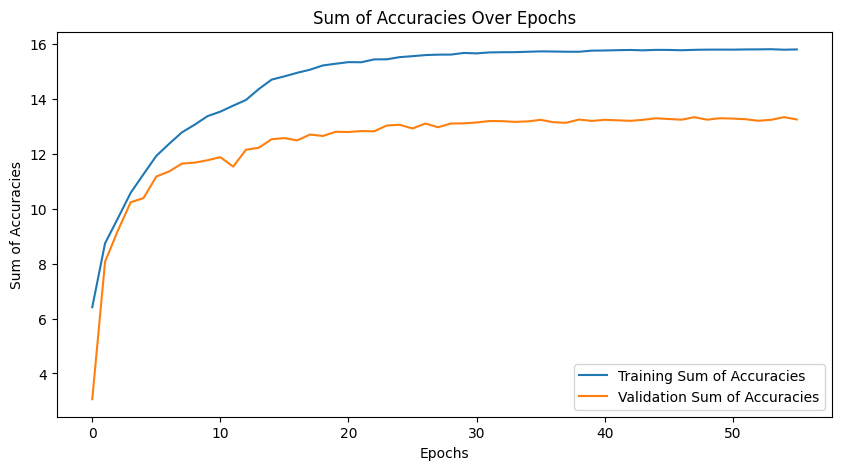

In [5]:
import matplotlib.pyplot as plt

# Plotting function to visualize training and validation accuracies
def plot_accuracies(trainer, model):
    min_length = min(len(model.training_accuracies), len(model.validation_accuracies))
    training_accuracies = model.training_accuracies[:min_length]
    validation_accuracies = model.validation_accuracies[:min_length]
    epochs = range(min_length)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, training_accuracies, label='Training Sum of Accuracies')
    plt.plot(epochs, validation_accuracies, label='Validation Sum of Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Sum of Accuracies')
    plt.title('Sum of Accuracies Over Epochs')
    plt.legend()
    plt.show()



# Call the plot function after training
plot_accuracies(trainer, model)

In [6]:
import torch.nn.functional as F

def evaluate_and_print_accuracies_with_confidences(model, dataloader):
    model.eval()
    model.to(device)
    accuracies = torch.zeros(len(num_classes_list))
    counts = torch.zeros(len(num_classes_list))
    all_preds = [[] for _ in range(len(num_classes_list))]
    all_confidences = [[] for _ in range(len(num_classes_list))]

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].T.to(device)

            logits = model(input_ids, attention_mask)

            for i, (logit, label) in enumerate(zip(logits, labels)):
                probs = F.softmax(logit, dim=1)
                preds = torch.argmax(probs, dim=1)
                accuracies[i] += (preds == label).sum().item()
                counts[i] += label.size(0)
                
                # Store predictions and confidence scores
                all_preds[i].extend(preds.cpu().numpy())
                all_confidences[i].extend(probs[range(len(preds)), preds].cpu().numpy())

    accuracies = accuracies / counts
    for i, acc in enumerate(accuracies):
        print(f"Accuracy for task {i+1}: {acc.item():.4f}")
        for pred, confidence in zip(all_preds[i], all_confidences[i]):
            print(f"Task {i+1} - Predicted class: {pred}, Confidence: {confidence:.4f}")

evaluate_and_print_accuracies_with_confidences(best_model, val_loader)


Accuracy for task 1: 0.9763
Task 1 - Predicted class: 1, Confidence: 0.9999
Task 1 - Predicted class: 1, Confidence: 0.9992
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 0.9999
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 0.9847
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 0, Confidence: 0.8003
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 0.9999
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Predicted class: 1, Confidence: 1.0000
Task 1 - Pre